## 05 - Image Restoration
### Part 1 - Noise and Denoising

In this notebook we deal with the problem of **noise** in images and the process of **denoising** images with *image restoration* methods.

Image restoration is concerned with improving the visual quality of images by using prior knowledge about the process that degraded the image, in particular *blur* and *noise*. In contrast with image enhancement techniques - in which a method is arbitrarily selected to allow improving the quality of images - restoration usually considers the image formation process:

$$g(\mathbf{x}) = \mathcal{N} \left\lbrace f(\mathbf{x}) * h(\mathbf{x}) \right\rbrace,$$
where $g$ is the observed or acquired image, $f$ is the ideal or original image, $h$ is the filter that explain the distortion caused in the image that is defined as a *spreading* of data from a given pixel $f(\mathbf{x})$ to a neighbourhood centred in $g(\mathbf{x})$, and $\mathcal{N}$ is a stochastic process that explains the *noise* in the image $g(\mathbf{x})$.

**Image restoration** is a process to obtain an estimate $\hat{f}$ of the original image $f$.

**Image denoise** deals with reversing the noise process. To make it more mathematically tractable, the image formation process often considered is one that assumes additive noise:

$$g(\mathbf{x}) = [f(\mathbf{x}) * h(\mathbf{x})] + n(\mathbf{x}),$$
where $n$ is a function that describes how noise is added to the image

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

### Noise distributions and artificial noise generation

Let us study a few noise distributions, which are often modelled via some parametric probability distribution, such as, for example:
* Uniform: all range of values that may be added to the image are equaly probable
* Gaussian (normal): the values to be added to the image follow a normal distribution, with some mean (usually zero) and standard deviation so that values far from the mean are less probable from both sides (positive and negative)

In addition to noise that is given by addition, there are also nonlinear noise process, for example
* Impulsive: represents an error in a given pixel, turning it into specific values. The most commonly observed are values 0 (also known as pepper noise), 255 (also known as salt noise), or both (salt and pepper). Therefore this only considers a limited set of possible values, thus 'impulsive'

Let us start with the uniform noise

In [3]:
def uniform_noise(size, prob=0.1):
    '''
    Generates a matrix with uniform noise in the range [0-255] to be added to an image
    
    :param size: tuple defining the size of the noise matrix 
    :param prob: probability for the uniform noise generation 
    :type prob: float
    :return matrix with uniform noise to be added to image
    '''
    
    levels = int((prob * 255) // 2)
    noise = np.random.randint(-levels, levels, size)
    
    return noise

In [4]:
img = imageio.imread("images/pattern2.png")

In [5]:
uni_noise = uniform_noise(img.shape, prob=0.15)
img_uni = np.clip(img.astype(int)+uni_noise, 0, 255)

hist_img,_ = np.histogram(img, bins=256, range=(0,255))
hist_uni,_ = np.histogram(img_uni, bins=256, range=(0,255))

<BarContainer object of 256 artists>

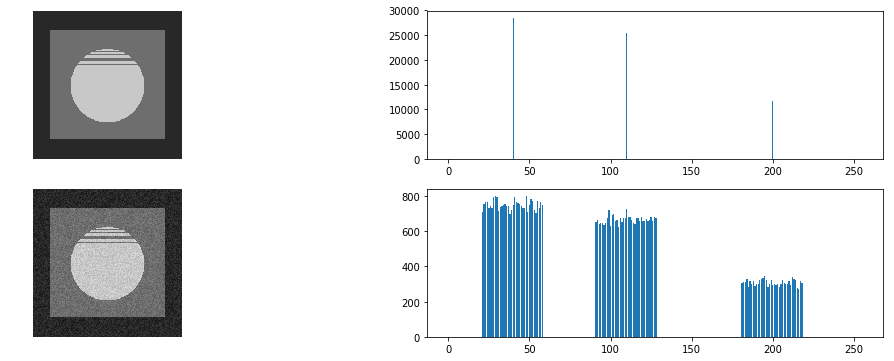

In [6]:
plt.figure(figsize=(18,6))
plt.subplot(221)
plt.imshow(img, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(222)
plt.bar(np.arange(256), hist_img)

plt.subplot(223)
plt.imshow(img_uni, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(224)
plt.bar(np.arange(256), hist_uni)

Note how the original image, which is noise-free has just three intensities values (40, 110 and 200). When we add uniform noise, values are added (or subtracted) from those intensities, producing a wider range of intensities around the original values. Note how the values are approximately uniform

In [7]:
def gaussian_noise(size, mean=0, std=0.01):
    '''
    Generates a matrix with Gaussian noise in the range [0-255] to be added to an image
    
    :param size: tuple defining the size of the noise matrix 
    :param mean: mean of the Gaussian distribution
    :param std: standard deviation of the Gaussian distribution, default 0.01
    :return matrix with Gaussian noise to be added to image
    '''
    noise = np.multiply(np.random.normal(mean, std, size), 255)
    
    return noise

In [8]:
gau_noise = gaussian_noise(img.shape, mean=0, std=0.05)
img_gau = np.clip(img.astype(int)+gau_noise, 0, 255)

hist_gau,_ = np.histogram(img_gau, bins=256, range=(0,255))

<BarContainer object of 256 artists>

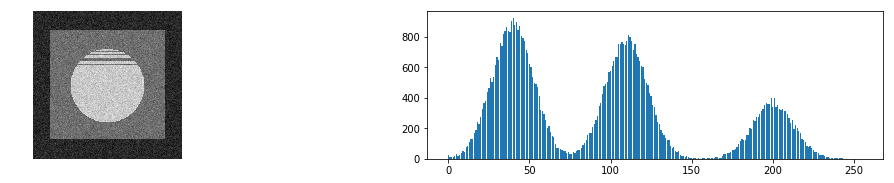

In [9]:
plt.figure(figsize=(18,6))
plt.subplot(221)
plt.imshow(img_gau, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(222)
plt.bar(np.arange(256), hist_gau)

In the case of Gaussian noise, the values are more likely around the intensity values, which are the mean of the distribution. Note the histogram shape, which indicates a multimodal normal distribution.

In [10]:
def impulsive_noise(image, prob=0.1, mode='salt_and_pepper'):
    '''
    Returns image with impulsive noise (0 and/or 255) to replace pixels in the image with some probability
    
    :param image: input image
    :param prob: probability for the impulsive noise generation 
    :param mode: type of noise, 'salt', 'pepper' or 'salt_and_pepper' (default)
    :type prob: float
    :return noisy image with impulsive noise
    '''

    noise = np.array(image, copy=True)
    for x in np.arange(image.shape[0]):
        for y in np.arange(image.shape[1]):
            rnd = np.random.random()
            if rnd < prob:
                rnd = np.random.random()
                if rnd > 0.5:
                    noise[x,y] = 255
                else:
                    noise[x,y] = 0
    
    return noise

In [11]:
img_imp = impulsive_noise(img, prob=0.1)

hist_imp,_ = np.histogram(img_imp, bins=256, range=(0,255))

<BarContainer object of 256 artists>

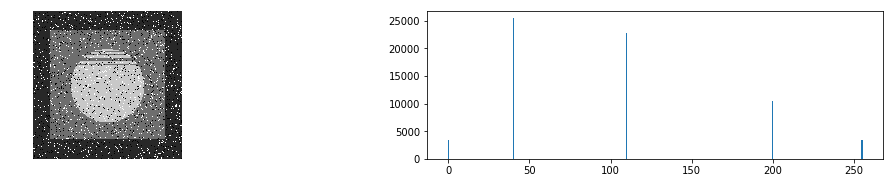

In [12]:
plt.figure(figsize=(18,6))
plt.subplot(221)
plt.imshow(img_imp, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(222)
plt.bar(np.arange(256), hist_imp)

### Denoising methods

In principle, considering an additive noise formation, you could just generate the noise and subtract it from the image. However, this may not produce the desired results. Therefore, smoothing filters such as the *Gaussian* filter, the *Median* filter may be used to reduce the variance locally in an attempt to denoise the images.

In [16]:
# generating noise and subtracting it from the image
uni_noise_new = uniform_noise(img.shape, prob=0.15)
img_uni_res = img_uni - uni_noise_new

def rmse(f,g):
    size = f.shape
    return np.sqrt(np.sum(np.square(f-g)))/ (size[0]*size[1])

print("Error between noisy and original: %.3f%%" % (rmse(img, img_uni)*100))
print("Error between 'restored' and original: %.3f%%" % (rmse(img_uni_res, img)*100))

Error between noisy and original: 4.282%
Error between 'restored' and original: 6.035%


The error did not increase much, and visualizing the images we confirm it indeed it added more noise to the image.

(-0.5, 255.5, 255.5, -0.5)

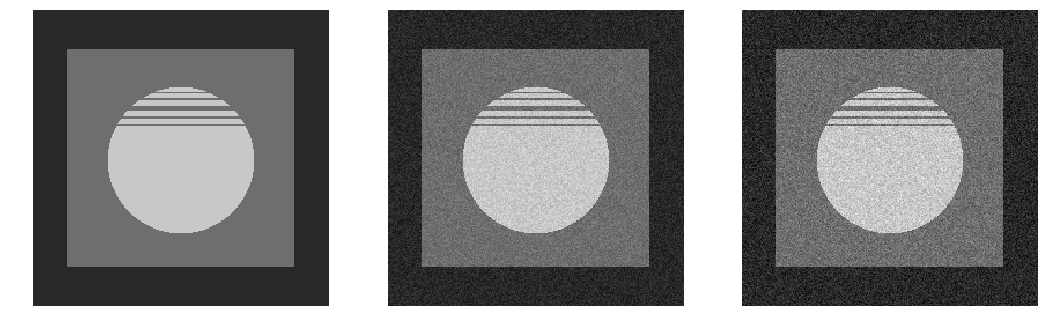

In [18]:
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.imshow(img, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(132)
plt.imshow(img_uni, cmap="gray", vmin=0, vmax=255)
plt.axis('off')
plt.subplot(133)
plt.imshow(img_uni_res, cmap="gray", vmin=0, vmax=255)
plt.axis('off')

### Denoinsing filters

Let us create filter to diminish the noise. There are many options, the most widely used are the mean, the Gaussian and the median. The choice of the method depends on the noise

All denoising filters work by reducing the local variance.

In [19]:
# importing the fft algorithms
# including the transform, inverse and the shift methods
from scipy.fftpack import fftn, ifftn, fftshift

In [21]:
# reading a new image and inclucing gaussian noise
f = imageio.imread("images/moon2.jpg")
g = f + gaussian_noise(f.shape, mean=0, std=0.08)
g = np.clip(g.astype(int), 0, 255)

# creating a 5x5 mean filter
w_mean = np.ones([5,5])/float(5*5)

def fft_imagefilter(g, w):
    ''' A function to filter an image g with the filter w
    '''
    # padding the filter so that it has the same size of the image
    pad1 = (g.shape[0]//2)-w.shape[0]//2
    wp = np.pad(w, (pad1,pad1-1), "constant",  constant_values=0)

    # computing the Fourier transforms
    W = fftn(wp)
    G = fftn(g)
    R = np.multiply(W,G)
    
    r = np.real(fftshift(ifftn(R)))
    return r

r_mean = fft_imagefilter(g, w_mean)

(-0.5, 255.5, 255.5, -0.5)

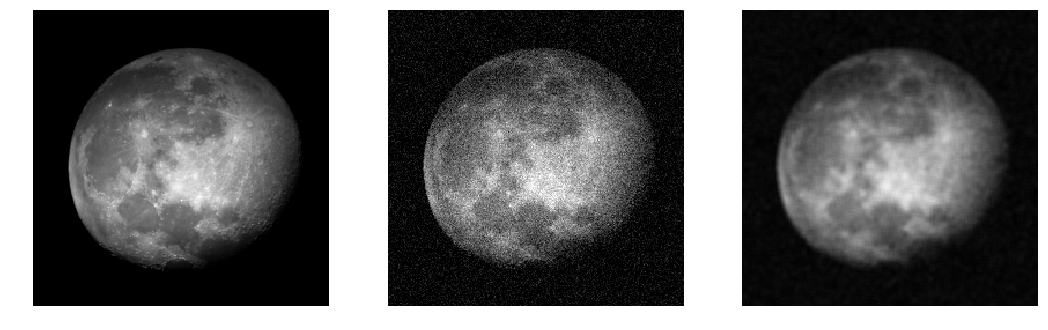

In [22]:
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.imshow(f, cmap="gray", vmin=0, vmax=255); plt.axis('off')
plt.subplot(132)
plt.imshow(g, cmap="gray", vmin=0, vmax=255); plt.axis('off')
plt.subplot(133)
plt.imshow(r_mean, cmap="gray", vmin=0, vmax=255); plt.axis('off')

When a filter is linear, we can compute with FFTs, but for order statistics filters, such as the median, it is harder to optimize. Here we do it pixel by pixel.

In [23]:
def medianfilter(g, k):
    ''' A median filter with size k
    '''
    a = k//2
    r = np.zeros(g.shape)
    for x in np.arange(a, g.shape[0]-a+1):
        for y in np.arange(a, g.shape[1]-a+1):
            med_region = np.median(g[x-a:x+a+1, y-a:y+a+1])
            r[x,y] = med_region
    
    return r

r_median = medianfilter(g,5)

Text(0.5,1,'median filter')

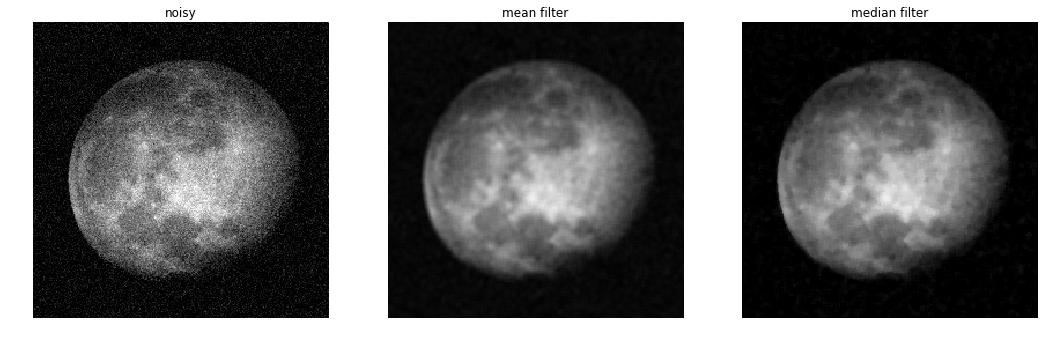

In [24]:
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.imshow(g, cmap="gray", vmin=0, vmax=255); plt.axis('off'); plt.title('noisy')
plt.subplot(132)
plt.imshow(r_mean, cmap="gray", vmin=0, vmax=255); plt.axis('off'); plt.title('mean filter')
plt.subplot(133)
plt.imshow(r_median, cmap="gray", vmin=0, vmax=255); plt.axis('off'); plt.title('median filter')

Let us do the same, but for an image with salt and pepper noise. Comparing a mean filter and a median filter with size $3\times 3$

In [25]:
img_imp = impulsive_noise(img, prob=0.2)

w_mean3 = np.ones([3,3])/float(3*3)
img_mean = fft_imagefilter(img_imp, w_mean3)
img_median = medianfilter(img_imp, 3)

Text(0.5,1,'median filter')

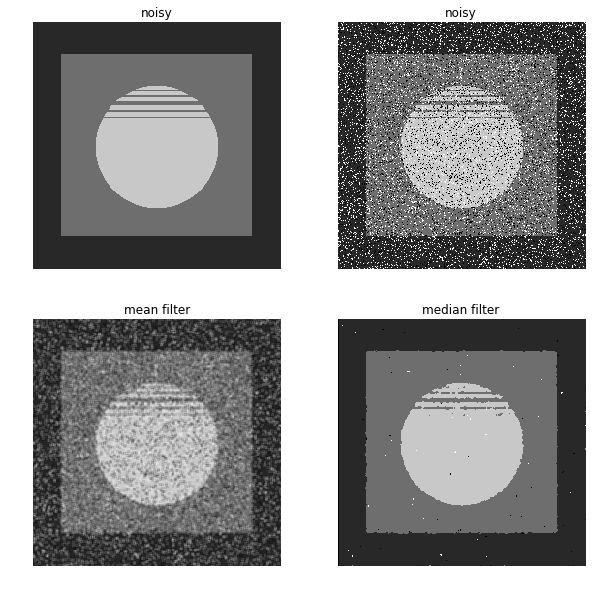

In [26]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(img, cmap="gray", vmin=0, vmax=255); plt.axis('off'); plt.title('noisy')
plt.subplot(222)
plt.imshow(img_imp, cmap="gray", vmin=0, vmax=255); plt.axis('off'); plt.title('noisy')
plt.subplot(223)
plt.imshow(img_mean, cmap="gray", vmin=0, vmax=255); plt.axis('off'); plt.title('mean filter')
plt.subplot(224)
plt.imshow(img_median, cmap="gray", vmin=0, vmax=255); plt.axis('off'); plt.title('median filter')

This shows how relevant is to know the noise process before desining a filter to remove it. 